In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
from scipy.stats import zscore
import math
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
%matplotlib inline

In [2]:
cols = ['symboling','normalized-losses','make','fuel-type','aspiration','num-of-doors','body-style','drive-wheels','engine-location','wheel-base','length','width','height','curb-weight','engine-type','num-of-cylinders','engine-size','fuel-system','bore','stroke','compression-ratio','horsepower','peak-rpm','city-mpg','highway-mpg','price']
car = pd.read_csv('imports-85.data', names = cols)
#print(car.columns)
#print(car.head(5))

In [3]:
features = ['normalized-losses','num-of-doors','wheel-base','length','width',
            'height','curb-weight','num-of-cylinders','engine-size','bore',
            'stroke','compression-ratio','horsepower','peak-rpm','city-mpg','highway-mpg','price']
car_features = car[features]
#car_features.info()
car_features.head(2)

,normalized-losses,num-of-doors,wheel-base,length,width,height,curb-weight,num-of-cylinders,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,?,two,88.6,168.8,64.1,48.8,2548,four,130,3.47,2.68,9.0,111,5000,21,27,13495
1,?,two,88.6,168.8,64.1,48.8,2548,four,130,3.47,2.68,9.0,111,5000,21,27,16500


In [4]:
mapper = {'one':1,
          'two':2,
          'three':3,
          'four':4,
          'five':5,
          'six':6,
          'seven':7,
          'eight':8,
          'nine':9,
          'ten':10}

In [5]:
car_features['num-of-doors'] = car_features['num-of-doors'].map(mapper)
car_features['num-of-cylinders'] = car_features['num-of-cylinders'].map(mapper)
car_features.head(5)

,normalized-losses,num-of-doors,wheel-base,length,width,height,curb-weight,num-of-cylinders,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,?,2.0,88.6,168.8,64.1,48.8,2548,4.0,130,3.47,2.68,9.0,111,5000,21,27,13495
1,?,2.0,88.6,168.8,64.1,48.8,2548,4.0,130,3.47,2.68,9.0,111,5000,21,27,16500
2,?,2.0,94.5,171.2,65.5,52.4,2823,6.0,152,2.68,3.47,9.0,154,5000,19,26,16500
3,164,4.0,99.8,176.6,66.2,54.3,2337,4.0,109,3.19,3.40,10.0,102,5500,24,30,13950
4,164,4.0,99.4,176.6,66.4,54.3,2824,5.0,136,3.19,3.40,8.0,115,5500,18,22,17450


In [6]:
car_features =  car_features.replace('?', np.nan)
car_features = car_features.astype(float)
#car_features.isnull().sum()
#car_features.shape

In [7]:
car_features['normalized-losses'].fillna(car_features['normalized-losses'].mean(), inplace=True)
car_features.dropna(inplace=True)
car_features.isna().sum()

normalized-losses    0
num-of-doors         0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
num-of-cylinders     0
engine-size          0
bore                 0
stroke               0
compression-ratio    0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

In [8]:
price = car_features['price']
car_normalized = (car_features - car_features.min())/(car_features.max() - car_features.min())
car_normalized_zscore = car_features.apply(zscore)
car_normalized['price'] = price
car_normalized_zscore['price'] = price

In [9]:
#print(car_normalized.head(3))

In [10]:
print(car_normalized_zscore.head(3))

   normalized-losses  num-of-doors  wheel-base    length     width    height  \
0           0.022223     -1.183216   -1.676508 -0.437848 -0.838318 -2.167049   
1           0.022223     -1.183216   -1.676508 -0.437848 -0.838318 -2.167049   
2           0.022223     -1.183216   -0.716906 -0.244536 -0.174968 -0.637836   

   curb-weight  num-of-cylinders  engine-size      bore    stroke  \
0    -0.012139         -0.440183     0.074427  0.516500 -1.823067   
1    -0.012139         -0.440183     0.074427  0.516500 -1.823067   
2     0.519746          1.875298     0.637831 -2.388308  0.697422   

   compression-ratio  horsepower  peak-rpm  city-mpg  highway-mpg    price  
0          -0.285836    0.230581  -0.21394 -0.694142    -0.572309  13495.0  
1          -0.285836    0.230581  -0.21394 -0.694142    -0.572309  16500.0  
2          -0.285836    1.418892  -0.21394 -1.010335    -0.720600  16500.0  


In [11]:
print(car_features['num-of-cylinders'].max())
print(car_features['num-of-cylinders'].min())
print(car_features['num-of-cylinders'].mean())

8.0
3.0
4.380208333333333


In [12]:
def knn_train_test(data, tr_cols, pr_col, k_par):
    
    #zamícháme data
    np.random.seed(1)
    random  = np.random.permutation(data.index)
    data = data.reindex(random)
    data = data.reset_index(drop=True)
    
    #rozdělíme na test a train data
    half = int((data.shape[0] + 1)/2)
    train = data[:half]
    test = data[half:]
    
    #iterujeme k parameter
    fin_rmse = {}
    for k in k_par:
        rmse = 0
        
        #init knn class
        knn = KNeighborsRegressor(n_neighbors=k,
                                  algorithm='brute')
        knn.fit(train[tr_cols], train[pr_col])

        #prediction
        prediction = knn.predict(test[tr_cols])
    
        #evaluation
        rmse = math.sqrt(mean_squared_error(test[pr_col], prediction))
        fin_rmse[k] = rmse 

    return fin_rmse

# All features

In [13]:
all_features = ['normalized-losses','num-of-doors','wheel-base','length','width',
            'height','curb-weight','num-of-cylinders','engine-size','bore',
            'stroke','compression-ratio','horsepower','peak-rpm','city-mpg','highway-mpg']
pre = 'price'
k_para = [1,2,3,4,5,6,7,8,9,10]

In [14]:
all_features_p = knn_train_test(car_normalized_zscore, all_features, pre, k_para)
all_features_p

{1: 3299.614982274447,
 2: 3718.8011880230524,
 3: 3597.7651597451336,
 4: 4080.614963037128,
 5: 4497.735035177891,
 6: 4853.159468021694,
 7: 4868.3583603934285,
 8: 4898.257658530783,
 9: 4922.270355099186,
 10: 4973.712052590432}

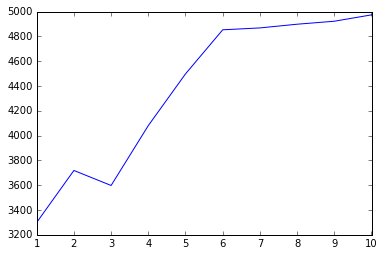

In [15]:
x = list(all_features_p.keys())
y = list(all_features_p.values())
plt.plot(x,y)
plt.show()

# Subjective feature selection

# Holdout validation

In [16]:
sel_features = ['num-of-cylinders','engine-size','horsepower']
pre = 'price'
k_para = [1,2,3,4,5,6,7,8,9,10]

In [17]:
sel_features_p = knn_train_test(car_normalized_zscore, sel_features, pre, k_para)
sel_features_p

{1: 2439.1863290689103,
 2: 2487.8088465094806,
 3: 2779.56080413595,
 4: 2835.621816451817,
 5: 3282.9090013660143,
 6: 3623.182970293779,
 7: 3998.6741882551555,
 8: 4302.184637023574,
 9: 4562.925932779299,
 10: 4741.485229038206}

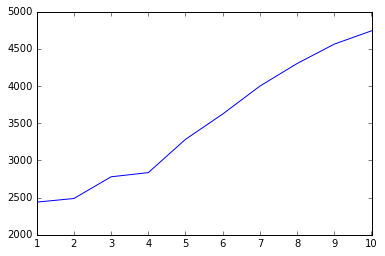

In [18]:
x = list(sel_features_p.keys())
y = list(sel_features_p.values())
plt.plot(x,y)
plt.show()

# K-fold cross validation

In [19]:
def knn_train_test_kfold(data, tr_cols, pr_col, k_par):
    
    #iterujeme k parameter
    fin_mse = {}
    for k in k_par:
        mse = 0
        #init knn class
        knn = KNeighborsRegressor(n_neighbors=k,
                                  algorithm='brute')
        
        #ini KFold class
        kf = KFold(n_splits=5,
                   shuffle=True,
                   random_state=1)
        
        mse = cross_val_score(knn,
                              data[tr_cols],
                              data[pr_col],
                              scoring='neg_mean_squared_error',
                              cv=kf)
        tmp = []
        for rec in mse:
            tmp.append(math.sqrt(abs(rec)))
        
        fin_mse[k] = tmp

    return fin_mse

In [26]:
sel_features = ['num-of-cylinders','engine-size','horsepower']
pre = 'price'
k_para = [1,2,3,4,5,6,7,8,9,10]

sel_features_kfold_p = knn_train_test_kfold(car_normalized_zscore, sel_features, pre, k_para)

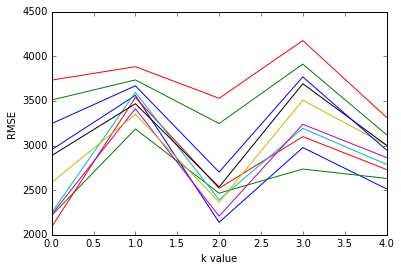

In [25]:
for k,v in sel_features_kfold_p.items():
    plt.plot(v)
    plt.xlabel('k value')
    plt.ylabel('RMSE')